In [66]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt
#import mpld3
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
tf.reset_default_graph()
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [96]:
history={}

In [67]:
Xwindow = 50   
horizon=80

In [68]:
#series_a = pd.read_csv('sine-wave-Copy1.csv', header=None)
#print(series_a.shape)
#series_a.head()
series = pd.read_csv('sine-wave.csv', header=None)
print(series.shape)
series.head()

(5001, 1)


,0
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [69]:
# this is just to find the zero crossings and thus the wavelength
#z1=series_a.shift(-1)
#np.where((series_a>0) & (z1<0))[0]

In [98]:
def plot_chart_to_file(best_epoch, best_value):

    # Plot Chart
    fig = plt.figure(dpi=300)

    # Subplot for Accuracy
    ax1 = fig.add_subplot(111)    
    ax1.plot(history.history['acc'], color='b', 
    label='Train Accuracy')
    ax1.plot(history.history['val_acc'], color='g', 
    label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower left', bbox_to_anchor=(0, -0.30))
    
    # Subplot for Loss
    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], color='y', 
    label='Train Loss')
    ax2.plot(history.history['val_loss'], color='c', 
    label='Validation Loss')
    ax2.plot(best_epoch, best_value, 'r+', label='Best Model')
    ax2.set_ylabel('Loss')   
    ax2.legend(loc='lower right', bbox_to_anchor=(1, -0.30))
    
    # Set Title
    plt.title('Model - Best Epoch (' + str(best_epoch) + ')')
    
    # .. and save..
    plt.savefig('Blog3_Model_Chart.png', 
    bbox_inches="tight")   

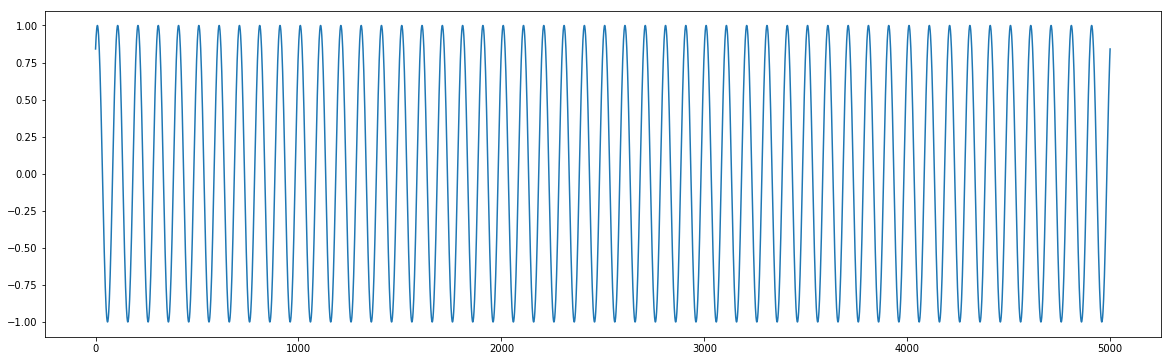

In [70]:
#pyplot.figure(figsize=(20,6))
#pyplot.plot(series_a.values)
#pyplot.show()
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

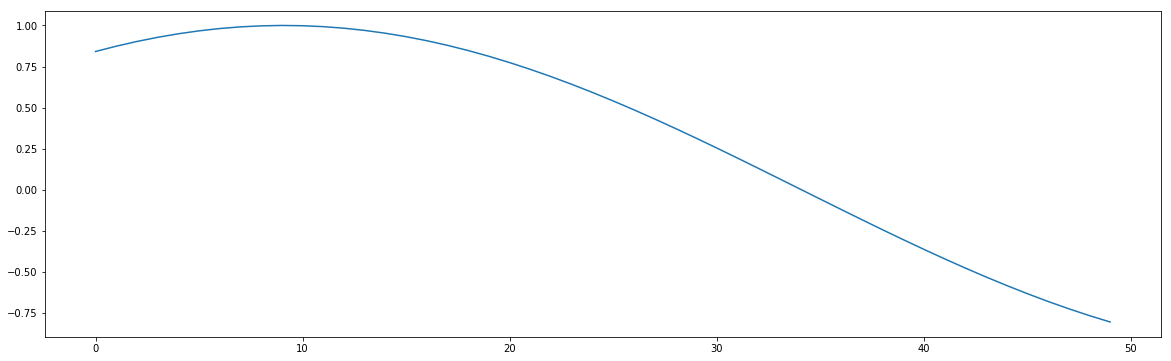

In [71]:
#pyplot.figure(figsize=(20,6))
#pyplot.plot(series_a.values[:50])
#pyplot.show()
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:50])
pyplot.show()


In [72]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values)
#scaled_a = scaler.fit_transform(series_a.values)
#print(series.values.min(),series.values.max())
series = pd.DataFrame(scaled)
#series_a = pd.DataFrame(scaled_a)

#print(series.values.min(),series.values.max())

In [73]:
window_size = Xwindow+horizon-1

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [74]:
nrow = round(0.8*series.shape[0])
#nrow_a = round(0.8*series_a.shape[0])

In [75]:
train1 = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]
#train_a = series_a.iloc[:nrow_a, :]
#test_a = series_a.iloc[nrow_a:,:]

In [76]:
nrow2=round(0.8*train1.shape[0])

In [77]:
from sklearn.utils import shuffle
train1 = shuffle(train1)       # ?? questionable, breaks the time order
print(train.shape)

(3118, 130)


In [78]:
train = train1.iloc[:nrow2, :]
validation=train1.iloc[nrow2:,:]

In [79]:
train_X = train.iloc[:,0:Xwindow]  # Xwindow columns
train_y = train.iloc[:,-1] 
validation_X = validation.iloc[:,0:Xwindow]  # Xwindow columns
validation_y = validation.iloc[:,-1] 

In [80]:
test_X = test.iloc[:,0:Xwindow]
test_y = test.iloc[:,-1]

In [81]:
train_X = train_X.values           # convert to ndarray
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values
validaion_X=validation_X.values
validaion_y=validation_y.values

In [82]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(validaion_X.shape)
print(validaion_y.shape)

(3118, 50)
(3118,)
(974, 50)
(974,)
(780, 50)
(780,)


In [88]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
validation_X=validation_X.values.reshape(validation_X.shape[0],validation_X.shape[1],1)

In [89]:
model = Sequential()
model.add(LSTM(input_shape = (Xwindow,1), units= 50, return_sequences = True))  # (50,1)
model.add(Dropout(0.5))
model.add(LSTM(256))   #LSTM(256)
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [113]:
patience = 2
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="auto",
                          verbose=0, 
                          patience=patience)

In [102]:
checkpoint = ModelCheckpoint('modelweights.hdf5', 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min')

In [117]:
#callbacks = [checkpoint, earlystop]
start = time.time()
model.fit(train_X,train_y,batch_size=200,epochs=25,validation_data=(validation_X, validation_y),callbacks=[earlystop])
print("> Training Time : ", time.time() - start)

Train on 3118 samples, validate on 780 samples
Epoch 1/25
3118/3118 [==============================] - 12s 4ms/step - loss: 0.0070 - val_loss: 1.5157e-04
Epoch 2/25
3118/3118 [==============================] - 11s 4ms/step - loss: 0.0042 - val_loss: 5.9446e-04
Epoch 3/25
3118/3118 [==============================] - 12s 4ms/step - loss: 0.0041 - val_loss: 1.7202e-04
> Training Time :  34.89517068862915


In [107]:
#model.load_weights('modelweights.hdf5')

In [106]:
#plot_chart_to_file(earlystop.stopped_epoch - patience, earlystop.best)